In [1]:
import sys, os
sys.path.append('../')
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from inversion_attacks import GradientInversion_Attack
from inversion_attacks.utils.utils import NumpyDataset, ConservativeStrategy, plot, multi_plot
from inversion_attacks.utils.models import LeNet, ConvNet
from inversion_attacks.utils.evaluation_metrics import psnr
from inversion_attacks.utils.consts import *
from inversion_attacks.utils.dataloader import construct_dataloaders

import numpy as np
from PIL import Image

from IQA_pytorch import SSIM 
import lpips 
import csv 


In [2]:
torch.manual_seed(5)
num_classes = 1000
channel = 3
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
setup = dict(device=device, dtype=torch.float)  
print(setup)
defs = ConservativeStrategy()
batch_size = 8

{'device': device(type='cuda', index=0), 'dtype': torch.float32}


In [3]:
# dm = torch.as_tensor(imagenet_mean, **setup)[:, None, None] 
# ds = torch.as_tensor(imagenet_std, **setup)[:, None, None] 

dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None] 


# torch.manual_seed(5)
# torch.cuda.manual_seed(5)
# np.random.seed(5)
loss_fn, dataloader, validloader =  construct_dataloaders('ImageNet', defs,data_path='/data2/imagenet2012')

tensor([337, 219, 862, 403,  11, 160, 700, 438])


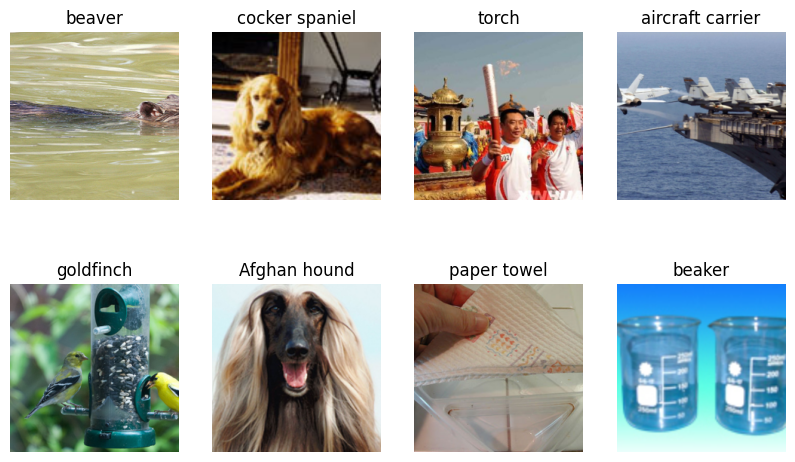

In [4]:
for i, (ground_truth,labels) in enumerate(dataloader):
    print(labels)
    ground_truth = ground_truth.to(device)
    labels = labels.to(device)
    multi_plot(ground_truth,ds,dm,labels,dataloader.dataset.classes)
    break

In [5]:
shape_img=tuple(ground_truth[0].shape)

print(shape_img)
print("seed label: ", labels, labels.shape)

(3, 224, 224)
seed label:  tensor([337, 219, 862, 403,  11, 160, 700, 438], device='cuda:0') torch.Size([8])


In [6]:
# net = getattr(torchvision.models, 'resnet50')()
# net = getattr(torchvision.models, 'resnet18')()
net = LeNet(channel=channel, hideen=37632, num_classes=num_classes)
# net = ConvNet(num_classes=num_classes)
net = net.to(device)

torch.Size([8, 3, 224, 224])


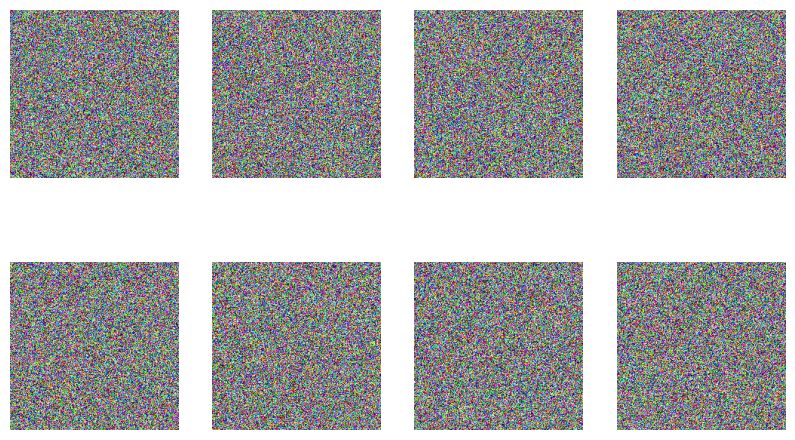

In [7]:
# x_init = torch.randn(ground_truth.shape,requires_grad=True,).to(**setup)
x_init = torch.randn((batch_size,) + (shape_img)).to(**setup)
print(x_init.shape)
multi_plot(x_init,ds,dm)
x_init.requires_grad = True

In [8]:
net.eval()
net.zero_grad()
ground_truth.requires_grad = True

In [9]:
pred = net(ground_truth)
loss, _, _ = loss_fn(pred, labels)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]
print(len(received_gradients))

14


In [10]:
# dlg_attacker_1 = GradientInversion_Attack(
#         net, 
#         shape_img, 
#         mean_std=(dm,ds), 
#         lr=1.0,#1.0, 
#         log_interval=100, 
#         num_iteration=3000, 
#         distancename="l2",
#         device=device,early_stopping=1000,
#         lr_decay=True,
#         optimize_label=True
#     )

# gs_attacker_1 = GradientInversion_Attack(
#             net,
#             shape_img,
#             mean_std=(dm,ds),
#             lr=0.001, #lr=1.0,
#             log_interval=100,
#             num_iteration=100,#10000,
#             tv_reg_coef=1e-6,
#             #tv_reg_coef=0.001,
#             distancename="cossim",
#             optimizer_class=torch.optim.Adam,
#             device=device,early_stopping=5000,
#             optimize_label=False,
#             lr_decay=True
#             # clamp_range=(0,1)
#         )

idlg_attacker_1 = GradientInversion_Attack(
        net,
        shape_img, 
        mean_std=(dm,ds),
        lr=1.0, #0.001,
        log_interval=100,
        num_iteration=100, #3000,
        distancename="l2",
        optimize_label=True,
        optimizer_class=torch.optim.SGD,
        lr_decay= True,
        device=device,early_stopping=1000
    )
    
# cpl_attacker_1 = GradientInversion_Attack(
#         net,
#         shape_img,
#         mean_std=(dm,ds),
#         lr=1.0,
#         log_interval=100,
#         num_iteration=500,
#         distancename="l2",
#         optimize_label=False,
#         lm_reg_coef=0.01,
#         device=device,early_stopping=1000
#     )

# group_num = 2
# gradinversion_attacker_1 = GradientInversion_Attack(
#         net,
#         shape_img,
#         num_iteration=500,
#         lr=1.0,
#         log_interval=100,
#         distancename="l2",
#         optimize_label=False,
#         bn_reg_layers=bn_reg_layers,
#         group_num=group_num,
#         tv_reg_coef=0.001,
#         l2_reg_coef=0.0001,
#         bn_reg_coef=0.001,
#         gc_reg_coef=0.001,
#         device=device,early_stopping=1000
#     )
    

iter=100: 0.0460636131465435, (best_iter=100: 0.0460636131465435)
PATH: ./Fake_x0_flow_0.png


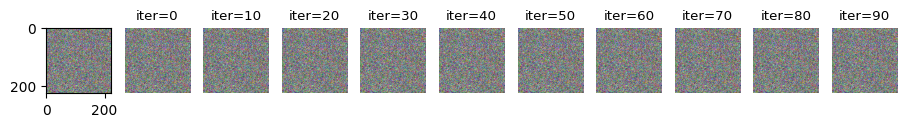

In [11]:
num_seeds=1

import traceback
try:
    # dlg_attacker_1.reset_seed(num_seeds)
    # result = dlg_attacker_1.attack(received_gradients, init_x=x_init)

    # gs_attacker_1.reset_seed(num_seeds)
    # result = gs_attacker_1.attack(received_gradients, init_x=x_init, batch_size=batch_size) #, labels=labels)

    idlg_attacker_1.reset_seed(num_seeds)
    result = idlg_attacker_1.attack(received_gradients, init_x=x_init, batch_size=batch_size)

    # cpl_attacker_1.reset_seed(num_seeds)
    # result = cpl_attacker_1.attack(received_gradients,labels=labels)

    # gradinversion_attacker_1.reset_seed(num_seeds)
    # result = gradinversion_attacker_1.group_attack(
    #     received_gradients, batch_size=1
    # )[0]
    
except:
    traceback.print_exc()



In [12]:
if len(result[1].shape) > 1:
    result_label = [torch.argmax(res).item() for res in result[1]]
else : result_label = result[1]
result_label

[403, 337, 862, 438, 11, 219, 700, 160]

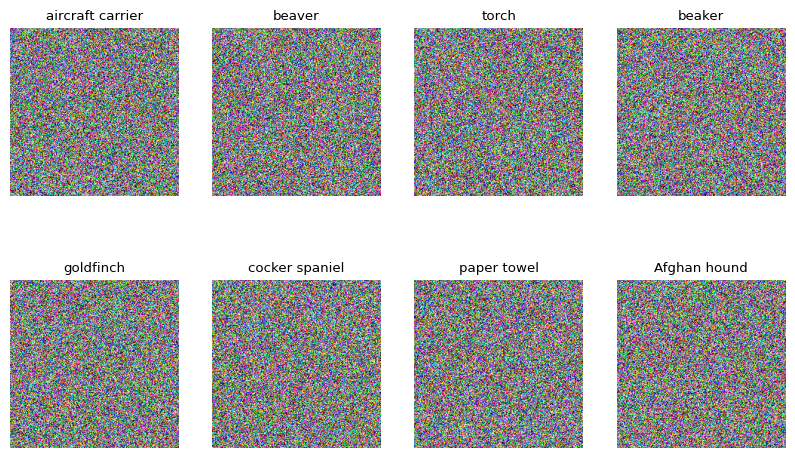

In [13]:
result[0].size()
result[0].requires_grad=False
multi_plot(result[0],ds,dm,labels=result_label,classes=dataloader.dataset.classes)

In [19]:
losses = idlg_attacker_1.get_best_loss()
losses

tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)

In [14]:
origin_labels = labels.tolist()

for i,current_label in enumerate(result_label):
    try:
        found = origin_labels.index(current_label)
    except:
        continue

    # evaluation
    output = result[0][i].detach().unsqueeze(0)
    matched_ground_truth = ground_truth[found].detach().unsqueeze(0)
    output.requires_grad=False
    matched_ground_truth.requires_grad=False

    test_mse = (output - matched_ground_truth).pow(2).mean()

    feat_mse = (net(output)- net(matched_ground_truth)).pow(2).mean()  
    test_psnr = psnr(output, matched_ground_truth, factor=1/ds)

    D = SSIM(channels=3)
    test_ssim = D(output.detach(), matched_ground_truth, as_loss=False).mean()

    lpips_loss = lpips.LPIPS(net='vgg', spatial=True).to(**setup)
    lpips_score = lpips_loss.forward(matched_ground_truth, output.detach()).mean()
    
    print(i)
    print(test_mse.item())
    print(feat_mse.item())
    print(test_ssim.item())
    print(test_psnr)
    print(lpips_score.item())
    print(str(dataloader.dataset.classes[labels[i]][0]))

    # break


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]


/home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
0
0.664003312587738
1.650536773922795e-06
0.0008807542617432773
7.798898220062256
0.8506917953491211
beaver
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
1
0.6726202368736267
1.711130721560039e-06
0.0006344940047711134
7.742900848388672
0.9109035134315491
cocker spaniel
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
2
0.766429603099823
1.6811821978990338e-06
0.0007540818769484758
7.175878047943115
0.9074788093566895
torch
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
3
0.9042606353759766
2.06